In [1]:
from importlib.metadata import version

import torch

torch.manual_seed(123)
print("TORCH VERSION :", version("torch"))
device = (
    "cuda" if torch.cuda.is_available() else "mps" if torch.backend.mps.is_available() else "cpu"
)
print("GPU  : ", device)

TORCH VERSION : 2.2.2
GPU  :  cuda


In [2]:
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Naive Self Attention Implementation
inputs = torch.rand(3, 5)
print(inputs)
attention_scores = inputs @ inputs.T
attention_weights = F.softmax(attention_scores, dim=-1)
attention_weights

tensor([[0.2961, 0.5166, 0.2517, 0.6886, 0.0740],
        [0.8665, 0.1366, 0.1025, 0.1841, 0.7264],
        [0.3153, 0.6871, 0.0756, 0.1966, 0.3164]])


tensor([[0.4070, 0.2828, 0.3103],
        [0.2295, 0.5150, 0.2555],
        [0.3217, 0.3264, 0.3519]])

This self-attention mechanism is also called "scaled dot-product attention".

In [4]:
# Self attention implementationw ith trainable weights
class SingleHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, blocksize, dropout=0.0, mask=False, qkv_bias=False):
        super().__init__()

        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.dropout = nn.Dropout(dropout)
        if mask:
            self.register_buffer("mask", torch.triu(torch.ones(blocksize, blocksize), diagonal=1))

    def forward(self, x):
        batch, token_count, _ = x.shape

        queries = self.w_query(x)
        keys = self.w_key(x)
        values = self.w_value(x)

        attention_scores = queries @ keys.transpose(1, 2)

        if hasattr(self, "mask"):
            attention_scores.masked_fill_(self.mask.bool()[:token_count, :token_count], -torch.inf)

        attention_weights = F.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)
        context_vector = attention_weights @ values
        return context_vector

In [5]:
inp = torch.rand(1, 10, 12)
d_in = d_out = inp.shape[-1]
sha = SingleHeadAttention(d_in, d_out, inp.shape[1], mask=True)
result = sha(inp)
result.shape

torch.Size([1, 10, 12])

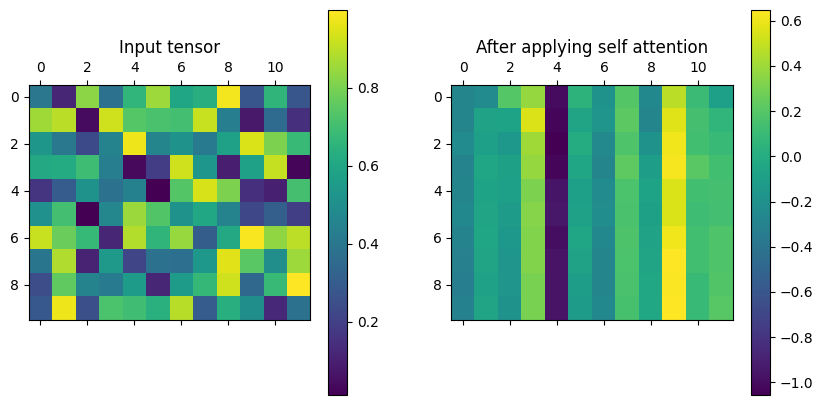

In [6]:
def plot(inp, result):
    import matplotlib.pyplot as plt

    # Create a figure with two subplots side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the same plot on both subplots
    cax1 = axs[0].matshow(inp.squeeze(0))
    fig.colorbar(cax1, ax=axs[0])
    cax2 = axs[1].matshow(result.detach().numpy().squeeze(0))
    fig.colorbar(cax2, ax=axs[1])

    axs[0].set_title("Input tensor")
    axs[1].set_title("After applying self attention")

    # Show the plot
    plt.show()


plot(inp, result)

In [7]:
# Multi Head Self Attention
class MultiHeadAttention_v1(nn.Module):
    def __init__(self, heads, d_in, d_out, blocksize, dropout=0.0, mask=False, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [
                SingleHeadAttention(d_in, d_out, blocksize, dropout, mask, qkv_bias)
                for _ in range(heads)
            ]
        )

        self.linear = nn.Linear(d_out * heads, d_out * heads)

    def forward(self, x):
        context_vec = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.linear(context_vec)

In [8]:
# for embedding_dim = 512 , head = 8
# d_in = 512/8 = 64

mha = MultiHeadAttention_v1(2, 12, 6, 10)
result = mha(inp)
result.shape

torch.Size([1, 10, 12])

In [9]:
# plot(inp,result)

In [10]:
class MultiHeadAttention(SingleHeadAttention):
    def __init__(self, num_heads, d_model, blocksize, dropout=0.0, mask=False, qkv_bias=False):
        super().__init__(d_model, d_model, blocksize, dropout, mask, qkv_bias)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads

        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch, num_token, embedding_dim = x.shape

        queries = self.w_query(x)
        keys = self.w_key(x)
        values = self.w_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        queries = queries.view(batch, num_token, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(batch, num_token, self.num_heads, self.head_dim).transpose(1, 2)
        values = values.view(batch, num_token, self.num_heads, self.head_dim).transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attention_scores = torch.matmul(queries, keys.transpose(-2, -1))
        if hasattr(self, "mask"):
            attention_scores.masked_fill_(self.mask.bool()[:num_token, :num_token], -float("inf"))

        attention_weights = F.softmax(attention_scores / keys.shape[-1] ** 0.5, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vector = torch.matmul(attention_weights, values)
        context_vector = (
            context_vector.transpose(1, 2).contiguous().view(batch, num_token, embedding_dim)
        )
        return self.linear(context_vector)

In [11]:
mha = MultiHeadAttention(2, 12, 10)
result = mha(inp)
result.shape

torch.Size([1, 10, 12])

In [12]:
# plot(inp,result)

In [13]:
class MultiHeadAttentionPyTorchSDP(nn.Module):
    def __init__(self, num_heads, d_model, block_size, mask=False, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_model % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.block_size = block_size
        self.head_dim = d_model // num_heads
        self.d_model = d_model

        self.qkv = nn.Linear(d_model, 3 * d_model, bias=qkv_bias)
        self.proj = nn.Linear(d_model, d_model)
        self.dropout = dropout

        self.register_buffer("mask", torch.triu(torch.ones(block_size, block_size), diagonal=1))

    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.reshape(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv.unbind(0)

        use_dropout = 0.0 if not self.training else self.dropout
        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True
        )

        # Combine heads, where self.d_model = self.num_heads * self.head_dim
        context_vec = (
            context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, embed_dim)
        )

        return context_vec

In [14]:
mhap = MultiHeadAttentionPyTorchSDP(2, 12, 10)
result = mhap(inp)
result.shape

torch.Size([1, 10, 12])

In [15]:
# plot(inp,result)

In [16]:
## Benchmark Test - CPU

In [16]:
torch.manual_seed(12345)
batch = 64
max_len = 1024
embedding_dim = 768
num_heads = 16

x = torch.rand(batch, max_len, embedding_dim)

In [26]:
%timeit SingleHeadAttention(embedding_dim,embedding_dim,x.shape[1],mask=True)(x)

534 ms ± 29.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit MultiHeadAttention_v1(num_heads,embedding_dim,embedding_dim//num_heads,max_len)(x)

6.62 s ± 119 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit MultiHeadAttention(num_heads,embedding_dim,max_len)(x)

In [18]:
%timeit MultiHeadAttentionPyTorchSDP(num_heads,embedding_dim,max_len)(x)

2.11 s ± 65.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [1]:
## GPU Benchmark Test

In [19]:
x = x.to(device)

In [22]:
%timeit SingleHeadAttention(embedding_dim,embedding_dim,x.shape[1],mask=True).to(device)(x)

1.47 s ± 69.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
x = x.to(device)
%timeit MultiHeadAttention_v1(num_heads,embedding_dim,embedding_dim//num_heads,max_len).to(device)(x)

The slowest run took 48.06 times longer than the fastest. This could mean that an intermediate result is being cached.
2.71 s ± 1.09 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit MultiHeadAttention(num_heads,embedding_dim,max_len).to(device)(x)

OutOfMemoryError: CUDA out of memory. Tried to allocate 4.00 GiB. GPU 0 has a total capacity of 11.72 GiB of which 2.06 GiB is free. Including non-PyTorch memory, this process has 9.39 GiB memory in use. Of the allocated memory 9.15 GiB is allocated by PyTorch, and 15.87 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [29]:
%timeit MultiHeadAttentionPyTorchSDP(num_heads,embedding_dim,max_len).to(device)(x)

152 ms ± 11.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit nn.Linear(embedding_dim,embedding_dim).to(device)(nn.MultiheadAttention(embedding_dim, num_heads).to(device)(x,x,x)[0])

505 ms ± 17.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
torch.cuda.empty_cache()

In [28]:
import pytorch_benchmark

model = MultiHeadAttentionPyTorchSDP(num_heads, embedding_dim, max_len).to("cuda")

# Create a benchmark object
results = pytorch_benchmark.benchmark(
    model, sample=x.to("cuda"), num_runs=10, batch_size=32, print_details=True
)

Warming up with batch_size=1: 100%|██████████████| 1/1 [00:00<00:00, 464.02it/s]


Warning! No positional inputs found for a module, assuming batch size is 1.
MultiHeadAttentionPyTorchSDP(
  2.36 M, 100.000% Params, 1.81 GMac, 100.000% MACs, 
  (qkv): Linear(1.77 M, 74.976% Params, 1.81 GMac, 100.000% MACs, in_features=768, out_features=2304, bias=False)
  (proj): Linear(590.59 k, 25.024% Params, 0.0 Mac, 0.000% MACs, in_features=768, out_features=768, bias=True)
)


Warming up with batch_size=1: 100%|██████████████| 1/1 [00:00<00:00, 454.17it/s]
STAGE:2024-03-15 23:24:22 102445:102445 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-15 23:24:22 102445:102445 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-15 23:24:22 102445:102445 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
Measuring inference for batch_size=1: 100%|████| 10/10 [00:00<00:00, 492.12it/s]
Unable to measure energy consumption. Device must be a NVIDIA Jetson.
Warming up with batch_size=32: 100%|██████████████| 1/1 [00:00<00:00,  8.42it/s]
STAGE:2024-03-15 23:24:22 102445:102445 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2024-03-15 23:24:22 102445:102445 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-03-15 23:24:22 102445:102445 ActivityProfilerController.cpp:324] Completed Stage: Post Processing
Measuring inference for batch_size=32: 100%|████| 10/10 [00

In [29]:
# print(yaml.dump(results))

device: cuda
flops: 1811939328
machine_info:
  cpu:
    architecture: x86_64
    cores:
      physical: 24
      total: 32
    frequency: 4.79 GHz
    model: 13th Gen Intel(R) Core(TM) i9-13900F
  gpus:
  - memory: 12282.0 MB
    name: NVIDIA GeForce RTX 4070 Ti
  memory:
    available: 25.11 GB
    total: 31.06 GB
    used: 5.38 GB
  system:
    node: pranav-pc-Legion-T5-26IRB8
    release: 6.5.0-25-generic
    system: Linux
memory:
  batch_size_1:
    max_inference: 49.38 MB
    max_inference_bytes: 51779584
    post_inference: 34.38 MB
    post_inference_bytes: 36050944
    pre_inference: 34.38 MB
    pre_inference_bytes: 36050944
  batch_size_32:
    max_inference: 994.38 MB
    max_inference_bytes: 1042683904
    post_inference: 34.38 MB
    post_inference_bytes: 36050944
    pre_inference: 34.38 MB
    pre_inference_bytes: 36050944
params: 2360064
timing:
  batch_size_1:
    cpu_to_gpu:
      human_readable:
        batch_latency: 623.298 us +/- 106.085 us [542.641 us, 880.718 us

In [34]:
import pandas as pd

pd.DataFrame.from_dict(results).T

,system,cpu,memory,gpus,batch_size_1,batch_size_32
machine_info,"{'system': 'Linux', 'node': 'pranav-pc-Legion-...",{'model': '13th Gen Intel(R) Core(TM) i9-13900...,"{'total': '31.06 GB', 'used': '5.38 GB', 'avai...","[{'name': 'NVIDIA GeForce RTX 4070 Ti', 'memor...",NaN,NaN
device,cuda,cuda,cuda,cuda,cuda,cuda
params,2360064,2360064,2360064,2360064,2360064,2360064
flops,1811939328,1811939328,1811939328,1811939328,1811939328,1811939328
timing,NaN,NaN,NaN,NaN,{'on_device_inference': {'metrics': {'batches_...,{'on_device_inference': {'metrics': {'batches_...
memory,NaN,NaN,NaN,NaN,"{'pre_inference_bytes': 36050944, 'max_inferen...","{'pre_inference_bytes': 36050944, 'max_inferen..."
